# Prueba Claro
## Frank Montenegro - frandak2@gmail.com

### importamos las librerias que vamos a usar

In [1]:
import pandas as pd
import geopandas as gpd
import libpysal as lp
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import contextily as ctx
import shapely.geometry as geom
%matplotlib inline

### redireccionamos la ruta del notebook

In [2]:
import os
g = os.getcwd()
g
path = 'D:\\repos\\PRUEBA_GEO'
os.chdir(path)

## Procedemos a leer los archivos shapefile
de antemanos sabemos que el shape MGN es la capa de centros poblados del igac, en este shape tenemos imforacion sobre la forma, tamanio y area de cada centro poblado del pais

In [3]:
MGN = gpd.read_file('data\MGN.shp')#leemos el shapefile
MGN.head(5) #observamos sus 5 primeras filas


,id,gid,dpto_ccdgo,mpio_ccdgo,cpob_ccdgo,setu_ccnct,shape_leng,shape_area,setu_ccdgo,geometry
0,2.0,10121.0,76,76001,76001000,760011000000001307,0.007526,0.000002,1307,"POLYGON ((-76.49561 3.42419, -76.49520 3.42387..."
1,3.0,10125.0,76,76001,76001000,760011000000001311,0.010818,0.000006,1311,"POLYGON ((-76.49901 3.42818, -76.49806 3.42770..."
2,2604.0,8188.0,63,63001,63001000,630011000000000061,0.176912,0.000408,0061,"POLYGON ((-75.64057 4.58468, -75.64055 4.58463..."
3,2605.0,8177.0,63,63001,63001000,630011000000000050,0.046058,0.000066,0050,"POLYGON ((-75.66499 4.53397, -75.66499 4.53397..."
4,6.0,10270.0,76,76001,76001000,760011000000002102,0.037957,0.000047,2102,"POLYGON ((-76.46221 3.43150, -76.46219 3.43150..."


en el siguiente shapefile asumimos que se trata de comparendos por el nombre de la carpeta

In [4]:
Comparendos = gpd.read_file('data\Comparendos_2019_Bogota_D_C-shp\ea5b4424-e796-4663-b73c-ba11d4d77a82202041-1-1g25ja2.nxl3.shp')#leemos el shapefile
Comparendos.to_crs(epsg=3116, inplace=True)


In [5]:
Comparendos.info()#observamos que tipo de info tiene el shapefile

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 402500 entries, 0 to 402499
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   OBJECTID    402500 non-null  int64   
 1   NUM_COMPAR  402500 non-null  object  
 2   FECHA_HORA  402500 non-null  object  
 3   ANO         402500 non-null  int64   
 4   MES         402500 non-null  object  
 5   MEDIO_DETE  402500 non-null  object  
 6   CLASE_VEHI  402500 non-null  object  
 7   TIPO_SERVI  402500 non-null  object  
 8   INFRACCION  402500 non-null  object  
 9   DES_INFRAC  402500 non-null  object  
 10  LOCALIDAD   402499 non-null  object  
 11  DIRECCION   402482 non-null  object  
 12  MUNICIPIO   402500 non-null  object  
 13  LATITUD     402500 non-null  float64 
 14  LONGITUD    402500 non-null  float64 
 15  geometry    402500 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(11)
memory usage: 49.1+ MB


### tenemos alrededor de 402.500 registros de comparendos, tambien observamos que por comparendo tenemos ID, fecha y hora, clase de vehiculo, infraccion, municipio, localidad, direccion, cordenadas (fundamental para hacer nuestro analisis espacial)


In [6]:
Comparendos.head(5)## examinamos como esta la informacion

,OBJECTID,NUM_COMPAR,FECHA_HORA,ANO,MES,MEDIO_DETE,CLASE_VEHI,TIPO_SERVI,INFRACCION,DES_INFRAC,LOCALIDAD,DIRECCION,MUNICIPIO,LATITUD,LONGITUD,geometry
0,3638634,11001000000022771563,2019-01-01,2019,ENERO,DEAP,AUTOMÓVIL,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,SUBA,CL 152A CR 99,BOGOTA,4.750385,-74.088710,POINT (998757.245 1017049.995)
1,3638635,11001000000022771541,2019-01-01,2019,ENERO,DEAP,AUTOMÓVIL,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,SUBA,CL 152A CR 99,BOGOTA,4.750385,-74.088710,POINT (998757.245 1017049.995)
2,3638636,11001000000022771542,2019-01-01,2019,ENERO,DEAP,AUTOMÓVIL,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,SUBA,CL 152A CR 99,BOGOTA,4.750467,-74.088823,POINT (998744.709 1017059.063)
3,3638637,11001000000022771452,2019-01-01,2019,ENERO,DEAP,AUTOMÓVIL,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,SUBA,CL 152A CR 99,BOGOTA,4.750358,-74.088554,POINT (998774.551 1017047.009)
4,3638648,11001000000022771565,2019-01-01,2019,ENERO,DEAP,CAMPERO,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,CHAPINERO,CL 81 CR 9,BOGOTA,4.664454,-74.052416,POINT (1002784.030 1007547.634)


cambiamos el formato de cada columna para poder trabajar de forma adecuada.

In [7]:
comp_copy = Comparendos.copy()
comp_copy = comp_copy.convert_dtypes()
comp_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402500 entries, 0 to 402499
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   OBJECTID    402500 non-null  Int64   
 1   NUM_COMPAR  402500 non-null  string  
 2   FECHA_HORA  402500 non-null  string  
 3   ANO         402500 non-null  Int64   
 4   MES         402500 non-null  string  
 5   MEDIO_DETE  402500 non-null  string  
 6   CLASE_VEHI  402500 non-null  string  
 7   TIPO_SERVI  402500 non-null  string  
 8   INFRACCION  402500 non-null  string  
 9   DES_INFRAC  402500 non-null  string  
 10  LOCALIDAD   402499 non-null  string  
 11  DIRECCION   402482 non-null  string  
 12  MUNICIPIO   402500 non-null  string  
 13  LATITUD     402500 non-null  Float64 
 14  LONGITUD    402500 non-null  Float64 
 15  geometry    402500 non-null  geometry
dtypes: Float64(2), Int64(2), geometry(1), string(11)
memory usage: 50.7 MB


La fecha al ser un tipo especial lo cambiaremos manualmente

In [8]:
comp_copy['FECHA_HORA'] = pd.to_datetime(comp_copy['FECHA_HORA'])
comp_copy['FECHA_HORA'] # en formato datetime

0        2019-01-01
1        2019-01-01
2        2019-01-01
3        2019-01-01
4        2019-01-01
            ...    
402495   2019-10-31
402496   2019-10-31
402497   2019-10-31
402498   2019-10-31
402499   2019-10-31
Name: FECHA_HORA, Length: 402500, dtype: datetime64[ns]

Como sabemos que tenemos un columna mes en tipo string la pasamos a tipo categorical.

In [9]:
comp_copy['MES'] = pd.Categorical(comp_copy['MES'], categories=[ 'ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE'], ordered=True)
comp_copy['MES']

0           ENERO
1           ENERO
2           ENERO
3           ENERO
4           ENERO
           ...   
402495    OCTUBRE
402496    OCTUBRE
402497    OCTUBRE
402498    OCTUBRE
402499    OCTUBRE
Name: MES, Length: 402500, dtype: category
Categories (12, object): ['ENERO' < 'FEBRERO' < 'MARZO' < 'ABRIL' ... 'SEPTIEMBRE' < 'OCTUBRE' < 'NOVIEMBRE' < 'DICIEMBRE']

eliminamos las columnas que no nos podrian traer inforacion relevante para el analisis, decidimos iliminar el ID y el # de comp por que no le suman informaciona nuestro datos, ademas eliminamos la direccion por que esta info esta contenida en la geometria

In [10]:
comp_copy.drop(columns=['OBJECTID','ANO', 'NUM_COMPAR', 'DIRECCION'], inplace=True)
comp_copy.head(5)

,FECHA_HORA,MES,MEDIO_DETE,CLASE_VEHI,TIPO_SERVI,INFRACCION,DES_INFRAC,LOCALIDAD,MUNICIPIO,LATITUD,LONGITUD,geometry
0,2019-01-01,ENERO,DEAP,AUTOMÓVIL,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,SUBA,BOGOTA,4.750385,-74.08871,POINT (998757.245 1017049.995)
1,2019-01-01,ENERO,DEAP,AUTOMÓVIL,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,SUBA,BOGOTA,4.750385,-74.08871,POINT (998757.245 1017049.995)
2,2019-01-01,ENERO,DEAP,AUTOMÓVIL,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,SUBA,BOGOTA,4.750467,-74.088823,POINT (998744.709 1017059.063)
3,2019-01-01,ENERO,DEAP,AUTOMÓVIL,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,SUBA,BOGOTA,4.750358,-74.088554,POINT (998774.551 1017047.009)
4,2019-01-01,ENERO,DEAP,CAMPERO,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,CHAPINERO,BOGOTA,4.664454,-74.052416,POINT (1002784.030 1007547.634)


## Que podemos averiguar con este dataset
### - cuantos tiempo tenemos de datos?
### - Cuantos municipios estan registrados?
### - cual es el total de comparendos mensuales por localidad?
### - cual es la densidad de comparendos anual?

miramos que rango de fecha tenemos en nuestro datos

<AxesSubplot:>

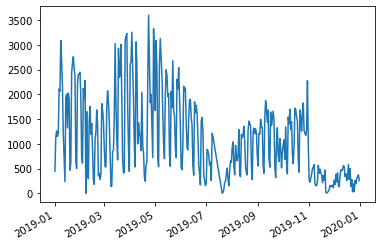

In [11]:
comp_copy['FECHA_HORA'].sort_values().value_counts().plot()# creamos un grafico rapido de el numero de comparendo por fecha para empezar a ver tendencias

tenemos al rededor del 1 ano de datos, que pertenecen al 2019, ademas observamos una caida de comparendos en la mitad del ano y de noviembre en adelante

observar la cantidad de municipios que estan involucrados en el dataset

In [12]:
comp_copy['MUNICIPIO'].value_counts()# cuenta el numero de municipios y la cantidad de registros en el dataset

BOGOTA    314252
BOGOTÁ     88248
Name: MUNICIPIO, dtype: Int64

todos nuestros datos estan ubicados en bogota, pero detectamos que existen 2 tipo de registros, entonces los trasladamos a un unico valor

In [13]:
comp_copy['MUNICIPIO'] = 'BOGOTA' #remplazamos todos los registros
comp_copy['MUNICIPIO'].value_counts() #confirmamos que todo este ok

BOGOTA    402500
Name: MUNICIPIO, dtype: int64

In [14]:
comp_copy['LOCALIDAD'].value_counts() 

CHAPINERO                38438
FONTIBON                 36175
MARTIRES                 32884
TEUSAQUILLO              30550
KENNEDY                  26469
USAQUEN                  22769
SUBA                     21974
ENGATIVA                 21624
BOSA                     21607
PUENTE ARANDA            20476
BARRIOS UNIDOS           20062
SANTA FE                 17174
USME                     13407
RAFAEL URIBE             11789
SAN CRISTOBAL            10425
TUNJUELITO                9861
ANTONIO NARIÑO            7939
CIUDAD BOLIVAR            7270
9-FONTIBON                4394
16-PUENTE ARANDA          2381
2-CHAPINERO               2312
8-KENNEDY                 2186
14-MARTIRES               2001
13-TEUSAQUILLO            1966
7-BOSA                    1957
11-SUBA                   1953
CANDELARIA                1939
10-ENGATIVA               1849
1-USAQUEN                 1786
5-USME                    1275
3-SANTA FE                1169
12-BARRIOS UNIDOS         1080
6-TUNJUE

Para poder estandarizar los nombres de las localidades es mejor tratar  su columna como string ya que si hacemos una operacion espacial para poder saber a donde pertenecen cada punto podria tardar demasiado para una tare tan sencilla.

In [15]:
name_local = comp_copy['LOCALIDAD'].str.split(pat='-')
name_local = name_local.fillna('NA')


In [26]:
new_name = []
for i in name_local:
    if len(i)>1:
        new_name.append(i[1])
    else:
        new_name.append(i[0])

In [29]:
comp_copy['LOCALIDAD'] = new_name
comp_copy['LOCALIDAD'].value_counts() 

CHAPINERO                40750
FONTIBON                 40569
MARTIRES                 34885
TEUSAQUILLO              32516
KENNEDY                  28655
USAQUEN                  24555
SUBA                     23927
BOSA                     23564
ENGATIVA                 23473
PUENTE ARANDA            22857
BARRIOS UNIDOS           21142
SANTA FE                 18343
USME                     14682
RAFAEL URIBE             11789
SAN CRISTOBAL            11091
TUNJUELITO               10692
ANTONIO NARIÑO            8438
CIUDAD BOLIVAR            7686
CANDELARIA                2092
 RAFAEL URIBE              702
SUMAPAZ                     59
                            23
Field was not enabled        6
Otro                         3
A                            1
Name: LOCALIDAD, dtype: int64

Observamos que tenemos una localidad con un espacio en el nombre y varios campos sin localidad, procederemos a acer una union espacial para pdoer saber a que localidad pertenecen

In [41]:
comp_copy['LOCALIDAD'].replace(' RAFAEL URIBE','RAFAEL URIBE',inplace=True)#remplazamos los valores por RAFAEL UTIBE SIN ESPACIO
comp_copy['LOCALIDAD'].replace(['A','Otro','Field was not enabled',''],'Sinlocalidad',inplace=True) # unificamos los campos sin localidad 
comp_copy['LOCALIDAD'].value_counts() 


CHAPINERO         40750
FONTIBON          40569
MARTIRES          34885
TEUSAQUILLO       32516
KENNEDY           28655
USAQUEN           24555
SUBA              23927
BOSA              23564
ENGATIVA          23473
PUENTE ARANDA     22857
BARRIOS UNIDOS    21142
SANTA FE          18343
USME              14682
RAFAEL URIBE      12491
SAN CRISTOBAL     11091
TUNJUELITO        10692
ANTONIO NARIÑO     8438
CIUDAD BOLIVAR     7686
CANDELARIA         2092
SUMAPAZ              59
Sinlocalidad         33
Name: LOCALIDAD, dtype: int64

In [62]:
sin_local = comp_copy[comp_copy['LOCALIDAD']=='Sinlocalidad'][['LOCALIDAD','geometry']]#selecionamos las geometrias sin localidad
sin_local = gpd.GeoDataFrame(sin_local)
sin_local.reset_index(inplace=True)

procederemos a hacer un overlap con las geometrias de las localidades (shapefile descargado de la datos abiertos) y y los puntos que no tienen localidad 

In [63]:
##lectura de localidades
local_BGT = gpd.read_file('data\localidades\localidades.shp')
local_BGT.to_crs(epsg=3116, inplace=True)
local_BGT = local_BGT[['NOMBRE','geometry']]
type(local_BGT)

geopandas.geodataframe.GeoDataFrame

ahora averiguaremos cuales el total de comparendo por mes en cada localidad

In [69]:
union = gpd.overlay(sin_local, local_BGT, how='union')
union

C:\Users\FRANKH~1\AppData\Local\Temp/ipykernel_10404/4216730765.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  union = gpd.overlay(sin_local, local_BGT, how='union')


,index,LOCALIDAD,NOMBRE,geometry
0,158217.0,Sinlocalidad,BARRIOS UNIDOS,POINT (999636.955 1008175.526)
1,314577.0,Sinlocalidad,BARRIOS UNIDOS,POINT (1002030.881 1009185.292)
2,353501.0,Sinlocalidad,BARRIOS UNIDOS,POINT (999949.470 1006954.240)
3,174238.0,Sinlocalidad,CHAPINERO,POINT (1003054.397 1008204.074)
4,397110.0,Sinlocalidad,CHAPINERO,POINT (1002472.534 1007965.917)
5,195851.0,Sinlocalidad,LOS MARTIRES,POINT (999181.979 1001388.266)
6,324810.0,Sinlocalidad,LOS MARTIRES,POINT (1000153.384 1001721.906)
7,369172.0,Sinlocalidad,LOS MARTIRES,POINT (999645.983 1000731.266)
8,314933.0,Sinlocalidad,SUBA,POINT (996893.433 1016425.813)
9,316829.0,Sinlocalidad,BOSA,POINT (988831.498 1000468.869)


In [114]:
for fid, inde in enumerate(union['index']):
    comp_copy.loc[int(inde),'LOCALIDAD'] = union['NOMBRE'][union['index']==int(inde)][fid]

# comp_copy.loc[383490]

In [115]:
comp_copy['LOCALIDAD'].value_counts()

CHAPINERO             40752
FONTIBON              40571
MARTIRES              34885
TEUSAQUILLO           32517
KENNEDY               28659
USAQUEN               24556
SUBA                  23928
BOSA                  23566
ENGATIVA              23477
PUENTE ARANDA         22860
BARRIOS UNIDOS        21145
SANTA FE              18344
USME                  14682
RAFAEL URIBE          12491
SAN CRISTOBAL         11092
TUNJUELITO            10694
ANTONIO NARIÑO         8438
CIUDAD BOLIVAR         7687
CANDELARIA             2092
SUMAPAZ                  59
LOS MARTIRES              3
RAFAEL URIBE URIBE        2
Name: LOCALIDAD, dtype: int64

In [116]:
comp_copy['CANTIDAD'] = 1 #creamos una columna nueva llamada cantidad con el valor 1 para poder hacer operaciones
sum_mes = comp_copy.groupby(['MES','LOCALIDAD'])['CANTIDAD'].count().reset_index()
sum_mes.head(5)

,MES,LOCALIDAD,CANTIDAD
0,ENERO,ANTONIO NARIÑO,1323
1,ENERO,BARRIOS UNIDOS,3137
2,ENERO,BOSA,2513
3,ENERO,CANDELARIA,252
4,ENERO,CHAPINERO,4728


In [47]:
# ##lectura de barrios
# barrios_BGT = gpd.read_file(r'data\barrios_SDP\barrios_SDP.shp')
# barrios_BGT.to_crs(epsg=3116, inplace=True)
# barrios_BGT = barrios_BGT[['NOMBRE','geometry']]





In [48]:

# barrios_BGT[['NOMBRE','geometry']].head(5)

# union = gpd.overlay(barrios_BGT,local_BGT,how='union')


C:\Users\FRANKH~1\AppData\Local\Temp/ipykernel_11348/3405026959.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  union = gpd.overlay(barrios_BGT,local_BGT,how='union')


In [ ]:
import libpysal
import esda

weights = libpysal.weights.Queen.from_dataframe(mergedData)  # generate spatial weights (Queen in this case)
spatial_auto = esda.Moran(mun[['population']], weights)  # calculate Moran's I

In [ ]:
Map = geemap.Map()


In [ ]:
Map.add_basemap('HYBRID')
Map.centerObject(ROI,16)
Map.addLayer(ROI, {}, "polygon01")

In [ ]:
Map

In [ ]:
ROI2 = gpd.read_file('Data\map_granja02_JV.geojson')
ROI2 = gmp.geopandas_to_ee(ROI2)

In [ ]:
Map.add_basemap('HYBRID')
Map.centerObject(ROI2,16)
Map.addLayer(ROI2, {}, "polygon01")

In [ ]:
Map